# **Prepare**

In [1]:
!pip install -q ultralytics timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import timm
from ultralytics import YOLO
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


In [3]:
import os

root = '/kaggle/input/eatlab/Dataset/Classification'
for cat in os.listdir(root):
    for label in os.listdir(os.path.join(root, cat)):
        path = os.path.join(root, cat, label)
        if os.path.isdir(path):
            count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
            print(f"{cat}_{label}: {count}")

dish_empty: 815
dish_kakigori: 380
dish_not_empty: 520
tray_empty: 362
tray_kakigori: 346
tray_not_empty: 491


In [4]:
data_yaml = '''
train: /kaggle/input/eatlab/Dataset/Detection/train/images
val: /kaggle/input/eatlab/Dataset/Detection/val/images
nc: 2
names: ['dish', 'tray']
'''
with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(data_yaml)


# **Detection - Yolov5n**

In [5]:
model_yolo = YOLO('yolov5n.pt')  

model_yolo.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov5n-custom',
    project='/kaggle/working',
    patience=5,
    optimizer='Adam',
    lr0=0.001  
)
!cp /kaggle/working/yolov5n-custom/weights/best.pt /kaggle/working/yolov5n_best.pt

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.31M/5.31M [00:00<00:00, 80.9MB/s]

Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov5n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov5n-custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=/kaggle/working, rect=False, resume=False, retin

100%|██████████| 755k/755k [00:00<00:00, 29.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4.3±1.8 MB/s, size: 40.9 KB)


train: Scanning /kaggle/input/eatlab/Dataset/Detection/train/labels... 1040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:06<00:00, 168.84it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/eatlab/Dataset/Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.3±0.3 MB/s, size: 41.0 KB)


val: Scanning /kaggle/input/eatlab/Dataset/Detection/val/labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:01<00:00, 169.52it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/eatlab/Dataset/Detection/val is not writeable, cache not saved.


Plotting labels to /kaggle/working/yolov5n-custom/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolov5n-custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.13G     0.9294      1.624      1.131         50        640: 100%|██████████| 65/65 [00:13<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.62it/s]

                   all        261        374      0.894      0.427      0.748      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.38G     0.8263     0.8577       1.06         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]

                   all        261        374      0.952      0.936      0.976      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.4G      0.822     0.7792      1.057         56        640: 100%|██████████| 65/65 [00:12<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]

                   all        261        374       0.93      0.913      0.954      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.41G     0.7742      0.704      1.039         44        640: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.27it/s]

                   all        261        374      0.968      0.945      0.985      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.43G     0.7448     0.6655       1.03         57        640: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]

                   all        261        374      0.945      0.944      0.971      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.44G     0.7425     0.6375      1.026         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]


                   all        261        374      0.984      0.957      0.983      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.46G     0.7376     0.6242      1.022         52        640: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.38it/s]

                   all        261        374      0.979      0.959      0.987      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.47G     0.7127     0.5976       1.01         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

                   all        261        374      0.982      0.951      0.985      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.48G     0.7034      0.597      1.012         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.38it/s]

                   all        261        374      0.977      0.948      0.984      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.5G     0.6856     0.5628      1.006         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]

                   all        261        374      0.985      0.971      0.985      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.51G     0.6845     0.5515     0.9997         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]

                   all        261        374      0.976      0.976      0.985      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.53G     0.6934      0.543      1.001         35        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]

                   all        261        374      0.991      0.958      0.981      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.54G     0.6663     0.5319     0.9952         33        640: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]

                   all        261        374      0.983      0.978      0.991      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.56G     0.6692     0.5125     0.9853         51        640: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.14it/s]

                   all        261        374      0.992       0.97       0.99      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.57G     0.6547     0.5166     0.9818         44        640: 100%|██████████| 65/65 [00:12<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]

                   all        261        374      0.982      0.969      0.987      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.59G     0.6508     0.4986     0.9859         45        640: 100%|██████████| 65/65 [00:12<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]

                   all        261        374       0.99      0.983      0.988       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.6G     0.6433      0.489     0.9798         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]

                   all        261        374      0.977      0.986       0.99      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.61G      0.613     0.4625     0.9651         48        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.53it/s]

                   all        261        374      0.991      0.981      0.989       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.63G     0.6184     0.4545     0.9666         49        640: 100%|██████████| 65/65 [00:12<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]

                   all        261        374      0.983      0.982      0.993      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.64G     0.6278     0.4575     0.9747         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]

                   all        261        374      0.988      0.971      0.988       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.66G     0.6289     0.4577     0.9798         49        640: 100%|██████████| 65/65 [00:12<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]

                   all        261        374       0.99      0.981       0.99      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.67G     0.6133      0.441     0.9613         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.56it/s]

                   all        261        374      0.991       0.98       0.99       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.69G     0.5948     0.4309     0.9594         40        640: 100%|██████████| 65/65 [00:12<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]

                   all        261        374      0.983      0.976      0.989      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.7G     0.5807     0.4173     0.9488         46        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.57it/s]

                   all        261        374      0.979      0.973      0.983      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.71G     0.5982     0.4407     0.9625         45        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.23it/s]

                   all        261        374      0.993      0.981      0.988      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.73G     0.5955     0.4311     0.9597         32        640: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]

                   all        261        374      0.991      0.981      0.988      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.74G     0.6025     0.4295     0.9658         33        640: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.47it/s]

                   all        261        374      0.994      0.974      0.989      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.76G     0.5796     0.4194     0.9498         52        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.17it/s]

                   all        261        374      0.975      0.972      0.987       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.77G     0.5789     0.4107     0.9555         54        640: 100%|██████████| 65/65 [00:12<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]

                   all        261        374      0.989       0.98      0.991       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.79G     0.5659     0.4062      0.951         38        640: 100%|██████████| 65/65 [00:12<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.04it/s]

                   all        261        374      0.996      0.976      0.989      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.8G     0.5557     0.3977     0.9436         39        640: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]

                   all        261        374      0.987      0.981       0.99      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.81G     0.5581     0.3898     0.9448         39        640: 100%|██████████| 65/65 [00:12<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]

                   all        261        374      0.991      0.984      0.989      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.83G     0.5625     0.3931     0.9513         40        640: 100%|██████████| 65/65 [00:12<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.36it/s]

                   all        261        374       0.99      0.975       0.99      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.84G      0.551     0.3853     0.9496         41        640: 100%|██████████| 65/65 [00:12<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.00it/s]

                   all        261        374      0.991      0.981      0.988      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.86G     0.5467     0.3839     0.9444         33        640: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.02it/s]

                   all        261        374      0.991      0.979      0.989      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.87G     0.5422     0.3713      0.939         43        640: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.38it/s]


                   all        261        374      0.991      0.976      0.988      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.89G     0.5395     0.3622     0.9342         51        640: 100%|██████████| 65/65 [00:12<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.24it/s]

                   all        261        374       0.99      0.981       0.99      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.9G     0.5431     0.3689     0.9391         49        640: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]

                   all        261        374      0.991      0.984       0.99      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.91G     0.5463     0.3721     0.9499         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.40it/s]

                   all        261        374      0.988      0.984      0.991      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.93G     0.5234     0.3544     0.9333         28        640: 100%|██████████| 65/65 [00:12<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

                   all        261        374      0.986      0.984       0.99      0.909


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.94G     0.4407     0.3039     0.9013         25        640: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]

                   all        261        374      0.992      0.979       0.99      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.96G     0.4377     0.2948     0.8987         26        640: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]

                   all        261        374       0.99      0.985      0.991       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.97G      0.436     0.2868     0.8873         18        640: 100%|██████████| 65/65 [00:12<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]

                   all        261        374      0.992      0.982      0.992      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.99G     0.4261     0.2739     0.8893         22        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]

                   all        261        374      0.991      0.981      0.992      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         3G     0.4282      0.276     0.8994         24        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]

                   all        261        374      0.992      0.983      0.991      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.01G     0.4146     0.2691     0.8933         20        640: 100%|██████████| 65/65 [00:12<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]

                   all        261        374      0.992      0.985      0.991      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.03G     0.4151     0.2648     0.8926         30        640: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]

                   all        261        374      0.992      0.986      0.991      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.04G     0.4126     0.2622     0.8887         29        640: 100%|██████████| 65/65 [00:12<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

                   all        261        374      0.989      0.983      0.991      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.06G     0.4052     0.2586     0.8796         23        640: 100%|██████████| 65/65 [00:12<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]

                   all        261        374      0.988      0.986      0.991      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.07G     0.3894     0.2504     0.8763         24        640: 100%|██████████| 65/65 [00:12<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]

                   all        261        374       0.99      0.987      0.991      0.916



50 epochs completed in 0.196 hours.
Optimizer stripped from /kaggle/working/yolov5n-custom/weights/last.pt, 5.3MB
Optimizer stripped from /kaggle/working/yolov5n-custom/weights/best.pt, 5.3MB

Validating /kaggle/working/yolov5n-custom/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv5n summary (fused): 84 layers, 2,503,334 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        261        374      0.988      0.986      0.991      0.918
                  dish        131        175          1      0.987      0.995      0.924
                  tray        180        199      0.975      0.985      0.987      0.913
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/yolov5n-custom


# **Detection - Yolov8n**

In [7]:
model_yolo = YOLO('yolov8n.pt')
model_yolo.train(
    data='/kaggle/working/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8n-custom',
    project='/kaggle/working',
    patience=5,
    optimizer='Adam',
    lr0 = 0.001
)

!cp /kaggle/working/yolov8n-custom/weights/best.pt /kaggle/working/yolov8n_best.pt



Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n-custom, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose

train: Scanning /kaggle/input/eatlab/Dataset/Detection/train/labels... 1040 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:01<00:00, 699.13it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/eatlab/Dataset/Detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.3±0.7 ms, read: 49.7±26.9 MB/s, size: 41.0 KB)


val: Scanning /kaggle/input/eatlab/Dataset/Detection/val/labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<00:00, 508.11it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/eatlab/Dataset/Detection/val is not writeable, cache not saved.


Plotting labels to /kaggle/working/yolov8n-custom/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/yolov8n-custom
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.37G     0.8969      1.661      1.154         50        640: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.56it/s]

                   all        261        374      0.768      0.551      0.779      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.61G     0.8191      0.863      1.085         50        640: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.23it/s]

                   all        261        374      0.847      0.781      0.878      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.61G      0.785     0.7787      1.061         56        640: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.13it/s]

                   all        261        374      0.883      0.906      0.959      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.61G     0.7594      0.714      1.057         44        640: 100%|██████████| 65/65 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]

                   all        261        374      0.934      0.949      0.971      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.61G     0.7385     0.6746      1.041         57        640: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]

                   all        261        374      0.885      0.939       0.97      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.61G      0.723     0.6408      1.033         46        640: 100%|██████████| 65/65 [00:11<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]

                   all        261        374      0.947      0.966      0.981      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.61G     0.7118     0.5984      1.019         52        640: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.34it/s]

                   all        261        374      0.978      0.916      0.981      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.61G     0.6975     0.5696      1.023         46        640: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.81it/s]

                   all        261        374      0.963      0.964      0.985      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.61G     0.6819     0.5629      1.012         50        640: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

                   all        261        374      0.994      0.953      0.987       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.61G      0.676     0.5419      1.016         46        640: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]

                   all        261        374      0.948      0.957      0.986      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.62G     0.6786      0.543      1.014         46        640: 100%|██████████| 65/65 [00:11<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]

                   all        261        374       0.99      0.971      0.986      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.64G     0.6705     0.5384      1.009         35        640: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]

                   all        261        374      0.989      0.963      0.987      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.66G     0.6417     0.5211     0.9965         33        640: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]

                   all        261        374       0.99      0.979      0.988      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.67G     0.6538     0.4959     0.9953         51        640: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]

                   all        261        374      0.955      0.971      0.989      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.69G     0.6435     0.5007     0.9916         44        640: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.47it/s]

                   all        261        374      0.987      0.978      0.987      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.71G     0.6386     0.4818     0.9973         45        640: 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]

                   all        261        374      0.992      0.978      0.989      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.72G     0.6296     0.4785       0.99         46        640: 100%|██████████| 65/65 [00:11<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.42it/s]

                   all        261        374      0.988      0.976      0.986      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.74G     0.6013      0.454     0.9739         48        640: 100%|██████████| 65/65 [00:11<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.56it/s]

                   all        261        374      0.989      0.976      0.989      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.76G     0.6123     0.4447     0.9782         49        640: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  6.47it/s]

                   all        261        374      0.985      0.974      0.983      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.78G     0.6105     0.4458     0.9824         50        640: 100%|██████████| 65/65 [00:11<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  5.90it/s]

                   all        261        374      0.995      0.961      0.983      0.869
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



20 epochs completed in 0.075 hours.
Optimizer stripped from /kaggle/working/yolov8n-custom/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolov8n-custom/weights/best.pt, 6.2MB

Validating /kaggle/working/yolov8n-custom/weights/best.pt...
Ultralytics 8.3.155 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        261        374      0.987      0.978      0.987      0.879
                  dish        131        175      0.994      0.976      0.989      0.891
                  tray        180        199      0.979       0.98      0.984      0.867
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/yolov8n-custom


# **Classification**

In [8]:
class CustomHierarchicalImageDataset(Dataset):
    def __init__(self, samples, transform=None, class_to_idx=None, classes=None):
        self.samples = samples
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.classes = classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

def load_all_samples(data_dir):
    samples = []
    classes = []
    class_to_idx = {}

    for main_dir in os.listdir(data_dir):
        for sub_dir in os.listdir(os.path.join(data_dir, main_dir)):
            full_class = f"{main_dir}_{sub_dir}"
            class_path = os.path.join(data_dir, main_dir, sub_dir)
            if not os.path.isdir(class_path): continue

            if full_class not in class_to_idx:
                class_to_idx[full_class] = len(classes)
                classes.append(full_class)

            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(class_path, fname)
                    samples.append((img_path, class_to_idx[full_class]))

    return samples, class_to_idx, classes

def split_dataset(samples, test_size=0.2):
    labels = [label for _, label in samples]
    train_samples, val_samples = train_test_split(
        samples, test_size=test_size, stratify=labels, random_state=42)
    return train_samples, val_samples

data_dir = '/kaggle/input/eatlab/Dataset/Classification'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

all_samples, class_to_idx, classes = load_all_samples(data_dir)
train_samples, val_samples = split_dataset(all_samples, test_size=0.2)

train_dataset = CustomHierarchicalImageDataset(train_samples, transform, class_to_idx, classes)
val_dataset = CustomHierarchicalImageDataset(val_samples, transform, class_to_idx, classes)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [9]:
def train_model(model, name, num_epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_acc = 0.0
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # -------- Training --------
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_acc = correct / total
        train_accs.append(train_acc)

        # -------- Validation --------
        model.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = correct / total
        val_accs.append(val_acc)

        # Tính precision, recall, f1 (macro cho đa lớp)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f"[{name}] Epoch {epoch+1}/{num_epochs} - "
              f"Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f} - "
              f"Precision: {precision:.4f} - Recall: {recall:.4f} - F1: {f1:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"/kaggle/working/{name}_best.pth")

    # === Confusion Matrix sau khi huấn luyện xong ===
    print(f"\nConfusion Matrix for {name} on validation set:")
    model.load_state_dict(torch.load(f"/kaggle/working/{name}_best.pth"))
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(class_to_idx.keys())  # ví dụ ['dish', 'tray', ...]
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

    return train_accs, val_accs


In [10]:
num_classes = len(class_to_idx)
models_to_train = {
    "resnet18": models.resnet18(pretrained=True),
    "mobilenetv2": models.mobilenet_v2(pretrained=True),
    "efficientnet_b0": timm.create_model("efficientnet_b0", pretrained=True)
}

for name, model in models_to_train.items():
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    else:
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

\n====== Huấn luyện RESNET18 ======
[resnet18] Epoch 1/5 - Train Acc: 0.8709 - Val Acc: 0.9520 - Precision: 0.9562 - Recall: 0.9458 - F1: 0.9503
[resnet18] Epoch 2/5 - Train Acc: 0.9854 - Val Acc: 0.9743 - Precision: 0.9708 - Recall: 0.9743 - F1: 0.9723
[resnet18] Epoch 3/5 - Train Acc: 0.9974 - Val Acc: 0.9777 - Precision: 0.9733 - Recall: 0.9769 - F1: 0.9749
[resnet18] Epoch 4/5 - Train Acc: 0.9979 - Val Acc: 0.9708 - Precision: 0.9682 - Recall: 0.9686 - F1: 0.9683
[resnet18] Epoch 5/5 - Train Acc: 1.0000 - Val Acc: 0.9691 - Precision: 0.9675 - Recall: 0.9696 - F1: 0.9683

Confusion Matrix for resnet18 on validation set:


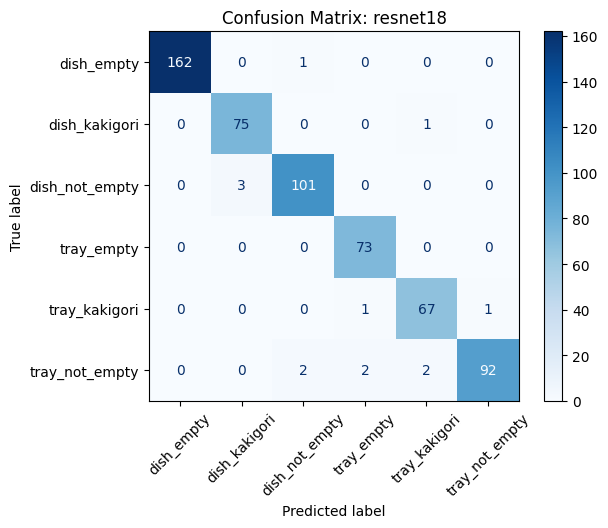

\n====== Huấn luyện MOBILENETV2 ======
[mobilenetv2] Epoch 1/5 - Train Acc: 0.8340 - Val Acc: 0.9297 - Precision: 0.9260 - Recall: 0.9268 - F1: 0.9243
[mobilenetv2] Epoch 2/5 - Train Acc: 0.9635 - Val Acc: 0.9605 - Precision: 0.9573 - Recall: 0.9579 - F1: 0.9573
[mobilenetv2] Epoch 3/5 - Train Acc: 0.9846 - Val Acc: 0.9691 - Precision: 0.9653 - Recall: 0.9688 - F1: 0.9668
[mobilenetv2] Epoch 4/5 - Train Acc: 0.9914 - Val Acc: 0.9708 - Precision: 0.9701 - Recall: 0.9678 - F1: 0.9684
[mobilenetv2] Epoch 5/5 - Train Acc: 0.9991 - Val Acc: 0.9743 - Precision: 0.9731 - Recall: 0.9724 - F1: 0.9725

Confusion Matrix for mobilenetv2 on validation set:


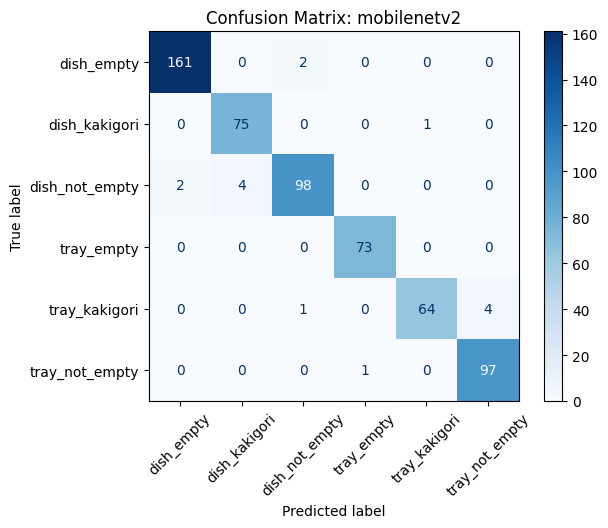

\n====== Huấn luyện EFFICIENTNET_B0 ======
[efficientnet_b0] Epoch 1/5 - Train Acc: 0.8022 - Val Acc: 0.9142 - Precision: 0.9047 - Recall: 0.9107 - F1: 0.9069
[efficientnet_b0] Epoch 2/5 - Train Acc: 0.9541 - Val Acc: 0.9503 - Precision: 0.9495 - Recall: 0.9447 - F1: 0.9464
[efficientnet_b0] Epoch 3/5 - Train Acc: 0.9773 - Val Acc: 0.9691 - Precision: 0.9660 - Recall: 0.9669 - F1: 0.9664
[efficientnet_b0] Epoch 4/5 - Train Acc: 0.9893 - Val Acc: 0.9623 - Precision: 0.9597 - Recall: 0.9590 - F1: 0.9593
[efficientnet_b0] Epoch 5/5 - Train Acc: 0.9949 - Val Acc: 0.9657 - Precision: 0.9630 - Recall: 0.9633 - F1: 0.9631

Confusion Matrix for efficientnet_b0 on validation set:


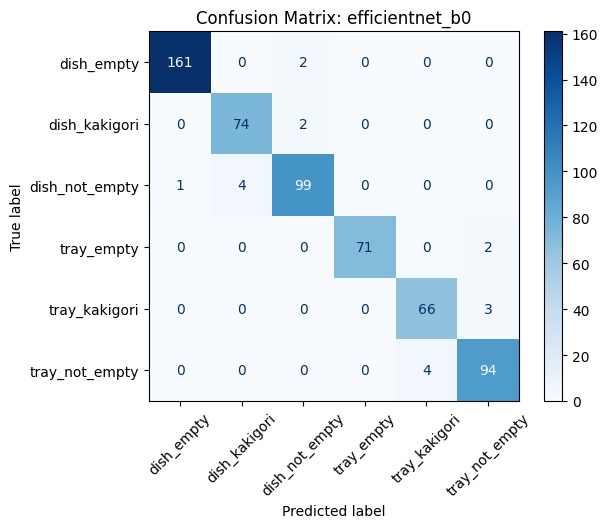

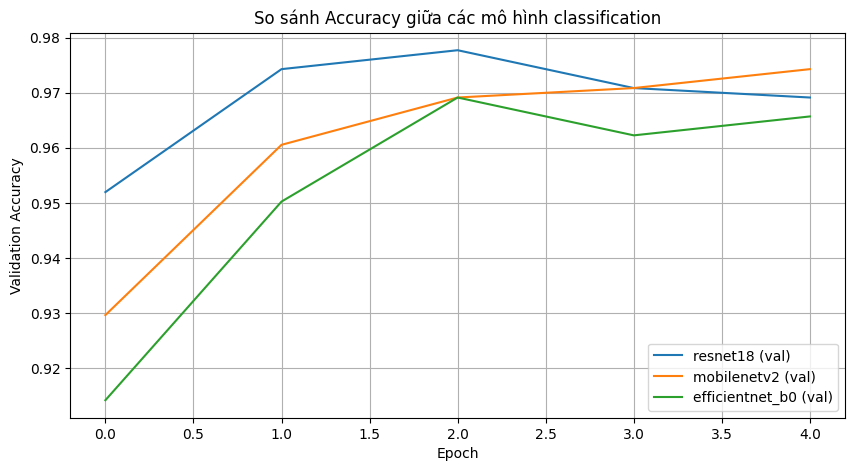

In [11]:
history = {}
for name, model in models_to_train.items():
    print(f"\\n====== Huấn luyện {name.upper()} ======")
    train_accs, val_accs = train_model(model, name, num_epochs=5)
    history[name] = (train_accs, val_accs)

plt.figure(figsize=(10, 5))
for name, (train_accs, val_accs) in history.items():
    plt.plot(val_accs, label=f"{name} (val)")
plt.title("So sánh Accuracy giữa các mô hình classification")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()